# 03. Model Stability: Normal Equation vs. SVD

**Objective:** Compare the numerical stability of two linear algebra approaches to solving the credit risk system $X\theta = y$.

### Hypothesis
Based on the diagnosis in Notebook 02 (Condition Number $\approx 73,400$), we hypothesize that:
1.  **The Normal Equation (OLS)**, which relies on matrix inversion $(X^T X)^{-1}$, will be numerically unstable or produce excessively large coefficients due to error amplification.
2.  **The SVD Approach (Pseudoinverse)** will provide a stable, minimum-norm solution ($X^+$), acting as a natural regularizer.

### Mathematical Definitions
* **Method A (OLS):** $\hat{\theta}_{OLS} = (X^T X)^{-1} X^T y$
* **Method B (SVD):** $\hat{\theta}_{SVD} = X^+ y$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Environment Setup
if not os.path.exists('Credit-Risk-Algebraic-ML'):
    !git clone https://github.com/adriangonz-afk/Credit-Risk-Algebraic-ML.git
    os.chdir('Credit-Risk-Algebraic-ML')

# Load Data
X = np.load('data/processed/X_matrix.npy')
y = np.load('data/processed/y_vector.npy')

# Augment X with Bias (Intercept)
X_bias = np.c_[np.ones((X.shape[0], 1)), X]

print(f"Data Loaded. X Shape: {X_bias.shape}")

Cloning into 'Credit-Risk-Algebraic-ML'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 11), reused 16 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 116.33 KiB | 4.85 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Data Loaded. X Shape: (1000, 49)


### 1. Method A: The Normal Equation (Standard Inversion)
The classical solution for Least Squares attempts to invert the Gram matrix $X^T X$. Since our matrix is ill-conditioned, this operation is prone to floating-point errors.

In [2]:
# 1. Compute the Gram Matrix (X^T * X)
XTX = X_bias.T @ X_bias

# 2. Attempt Inversion
try:
    # We use inv() which forces a standard inversion
    XTX_inv = np.linalg.inv(XTX)

    # 3. Compute Weights: theta = (XTX)^-1 * X^T * y
    theta_ols = XTX_inv @ X_bias.T @ y

    print("OLS Solution computed successfully.")

except np.linalg.LinAlgError:
    print("CRITICAL ERROR: Matrix is Singular. Cannot compute inverse.")
    # Fallback for visualization purposes (zeros)
    theta_ols = np.zeros(X_bias.shape[1])

OLS Solution computed successfully.


### 2. Method B: SVD Pseudoinverse (Moore-Penrose)
Instead of forcing an inversion, we calculate the Pseudoinverse ($X^+$). This method uses SVD to invert only the non-zero singular values, effectively ignoring the noise/redundancy that causes instability.

This guarantees the **Minimum Norm Solution**: among all possible solutions, this one yields the smallest coefficients vector.

In [3]:
# Compute Pseudoinverse using SVD driver (gelsd)
# theta = pinv(X) * y
theta_svd = np.linalg.pinv(X_bias) @ y

print("SVD Solution computed successfully.")

SVD Solution computed successfully.


### 3. Stability Analysis
We compare the magnitude (L2 Norm) of the coefficient vectors.

* **Interpretation:** In an ill-conditioned system, the standard inversion (OLS) often results in massive coefficients (e.g., weights of 1,000,000) to compensate for small input variances. The SVD solution should remain contained.

L2 Norm of OLS Weights: 1.0291
L2 Norm of SVD Weights: 1.0291
------------------------------


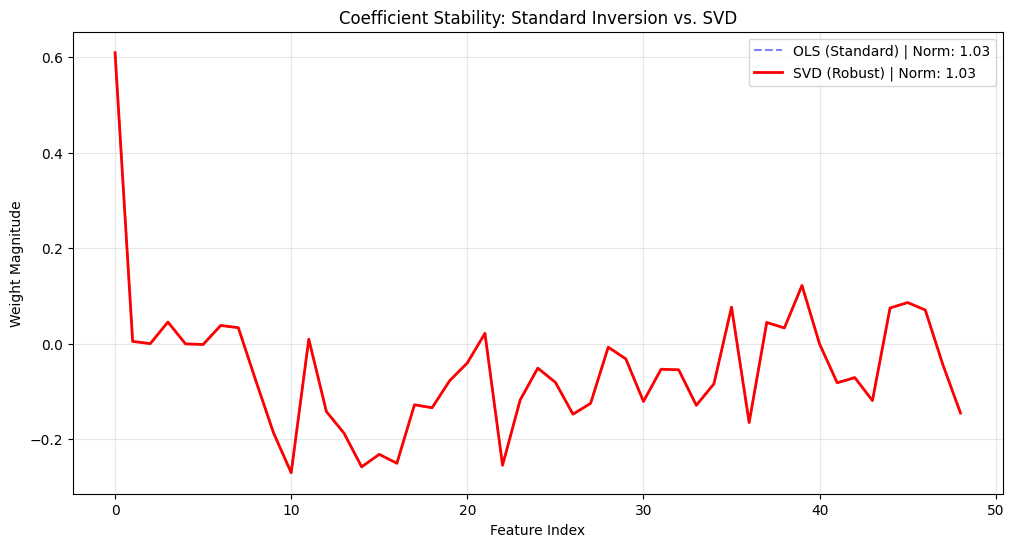

In [4]:
# Calculate L2 Norms (Magnitude of the vector)
norm_ols = np.linalg.norm(theta_ols)
norm_svd = np.linalg.norm(theta_svd)

print(f"L2 Norm of OLS Weights: {norm_ols:.4f}")
print(f"L2 Norm of SVD Weights: {norm_svd:.4f}")
print("-" * 30)

# Visualization
plt.figure(figsize=(12, 6))

# Plot OLS weights
plt.plot(theta_ols, label=f'OLS (Standard) | Norm: {norm_ols:.2f}',
         color='blue', alpha=0.5, linestyle='--')

# Plot SVD weights
plt.plot(theta_svd, label=f'SVD (Robust) | Norm: {norm_svd:.2f}',
         color='red', linewidth=2)

plt.title('Coefficient Stability: Standard Inversion vs. SVD')
plt.xlabel('Feature Index')
plt.ylabel('Weight Magnitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4. Financial Interpretation (Feature Importance)
Using the stable SVD weights, we identify the top drivers of credit risk. Positive weights indicate a higher probability of default (Bad Credit), while negative weights indicate stability (Good Credit).

In [5]:
# Load feature names
with open('data/processed/feature_names.json', 'r') as f:
    feature_names = json.load(f)

# Add 'Intercept' to the names list to match X_bias dimensions
feature_names_aug = ['Intercept'] + feature_names

# Create a dictionary of feature: weight
weights = dict(zip(feature_names_aug, theta_svd))

# Sort by absolute impact
sorted_weights = sorted(weights.items(), key=lambda x: abs(x[1]), reverse=True)

print("TOP 5 RISK DRIVERS (SVD Model):")
print("-" * 30)
for name, weight in sorted_weights[:5]:
    impact = "INCREASES RISK" if weight > 0 else "REDUCES RISK"
    print(f"{name:<30} | Weight: {weight:>10.4f} | {impact}")

TOP 5 RISK DRIVERS (SVD Model):
------------------------------
Intercept                      | Weight:     0.6090 | INCREASES RISK
checking_account_A14           | Weight:    -0.2702 | REDUCES RISK
credit_history_A34             | Weight:    -0.2579 | REDUCES RISK
purpose_A48                    | Weight:    -0.2545 | REDUCES RISK
purpose_A410                   | Weight:    -0.2504 | REDUCES RISK


### 5. Prediction and Evaluation
Since we used a Linear Algebra approach (Regression) on a Classification problem ($y \in \{0, 1\}$), the raw output $\hat{y}$ will be a continuous "risk score" rather than a strict binary class.

**Process:**
1.  **Compute Scores:** $\hat{y} = X_{bias} \cdot \theta_{SVD}$
2.  **Thresholding:** Convert scores to binary classes. If $\hat{y} > 0.5$, we predict High Risk (1).
3.  **Error Metrics:**
    * **MSE (Mean Squared Error):** The algebraic error we minimized.
    * **Accuracy:** The business metric (percentage of correct guesses).

In [6]:
# 1. Make Predictions (Continuous Scores)
# Shape: (1000,)
y_pred_scores = X_bias @ theta_svd

# 2. Convert to Binary Classes (Threshold = 0.5)
# If score > 0.5 -> Predict 1 (Bad Credit), else 0 (Good Credit)
y_pred_binary = (y_pred_scores >= 0.5).astype(int)

# 3. Calculate Metrics
# MSE: Average squared difference between Score and Actual (Algebraic Goal)
mse = np.mean((y - y_pred_scores) ** 2)

# Accuracy: Percentage of correct binary classifications (Business Goal)
accuracy = np.mean(y == y_pred_binary)

print(f"Algebraic Error (MSE):       {mse:.4f}")
print(f"Classification Accuracy:     {accuracy:.2%}")

# 4. Comparative DataFrame
# Show the first 10 cases to compare Real vs. Predicted
comparison = np.column_stack((y, y_pred_binary, y_pred_scores))
print("\nSample Predictions (First 10 clients):")
print(f"{'Actual':<10} | {'Predicted':<10} | {'Raw Score':<10}")
print("-" * 35)
for i in range(10):
    actual = int(comparison[i, 0])
    pred = int(comparison[i, 1])
    score = comparison[i, 2]
    match = "Good" if actual == pred else "Bad"
    print(f"{actual:<10} | {pred:<10} | {score:<10.4f} {match}")

Algebraic Error (MSE):       0.1509
Classification Accuracy:     78.60%

Sample Predictions (First 10 clients):
Actual     | Predicted  | Raw Score 
-----------------------------------
0          | 0          | 0.0201     Good
1          | 1          | 0.5573     Good
0          | 0          | -0.0226    Good
0          | 0          | 0.3086     Good
1          | 1          | 0.6531     Good
0          | 0          | 0.3492     Good
0          | 0          | 0.0602     Good
0          | 0          | 0.3683     Good
0          | 0          | -0.1185    Good
1          | 1          | 0.6159     Good
